Este notebook pretende analisar a preservação estrutural de series temporais após redução de dimensionalidade. Para isso serão selecionados datasets com alta dimensionalidade da biblioteca AEON e aplicados variações do algoritimo do PAA (Piecewise Aggregate Approximation) para redução de dimensionalidade aplicando diferentes taxas perceptuais de redução.

Para medir essa preservação da estrutura iremos calcular uma matriz de distâncias de cada série temporal antes e depois da redução de dimensionalidade utilizando a distância euclidiana. Assim poderemos comparar se após a redução de dimensionalidade os K vizinhos mais próximos de cada série temporal permanecem os mesmos.

A partir da quantidade de vizinhos preservados após a redução de dimensionalidade, será calculada uma métrica de preservação de vizinhança definida como um valor entre 0 e 1, onde 1 indica que todos os K vizinhos mais próximos permaneceram os mesmos e 0 indica que nenhum vizinho próximo permaneceu o mesmo.


In [1]:
# Importa algumas bibliotecas necessárias
import numpy as np
import pandas as pd
import os

from aeon.datasets import load_classification
from aeon.distances import euclidean_distance


In [2]:
# Começamos definindo a lista de datasets que serão utilizados para os experimentos
# Estes são datasets de alta dimensionalidade da biblioteca AEON
high_dim_datasets = [
  'ACSF1',
  'CinCECGTorso',
  'EOGHorizontalSignal',
  'EOGVerticalSignal',
  'EthanolLevel',
  'HandOutlines',
  'Haptics',
  'HouseTwenty',
  'InlineSkate',
  'Mallat',
  'MixedShapesRegularTrain',
  'MixedShapesSmallTrain',
  'Phoneme',
  'PigAirwayPressure',
  'PigArtPressure',
  'PigCVP',
  'Rock',
  'SemgHandGenderCh2',
  'SemgHandMovementCh2',
  'SemgHandSubjectCh2',
  'StarLightCurves',
]

In [3]:
# Define as taxas de redução de dimensionalidade a serem testadas (%)
reduction_rates = [
    0.95,
    0.9,
    0.8,
    0.7,
    0.6,
    0.5,
    0.4,
    0.3,
    0.2,
    0.1
]

In [4]:
# Para facilitar a comparação de séries em diferentes escalas, 
# podemos aplicar uma função de normalização nas séries.
# Assim todas as séries ficarão com média 0 e desvio padrão 1.
def znorm(x):
  x_znorm = (x - np.mean(x)) / np.std(x)
  return x_znorm

In [5]:
# Define as funções de agregação que podem ser usadas para reduzir a dimensionalidade no PAA
aggregations = {
    'average': lambda x: np.mean(x),
    'median': lambda x: np.median(x),
    'max': lambda x: np.max(x),
    'min': lambda x: np.min(x),
    'sum': lambda x: np.sum(x),
    'variance': lambda x: np.var(x),
    'std': lambda x: np.std(x),
    'iqr': lambda x: np.subtract(*np.percentile(x, [75, 25])),
    'first': lambda x: x[0],
    'central': lambda x: x[len(x)//2],
    'last': lambda x: x[-1],
    'max-min': lambda x: np.max(x) - np.min(x),
    'avg-max': lambda x: np.abs((np.mean(x) - np.max(x))),
    'avg-min': lambda x: np.abs((np.mean(x) - np.min(x))),
    'random': lambda x: np.random.choice(x)
}

In [6]:
# Implementa o algoritmo PAA (Piecewise Aggregate Approximation)
# Recebe uma série temporal 's', o tamanho desejado 'w' e a função de agregação 'agg'
def PAA(s, w, agg='average'):
    if agg not in aggregations:
        raise ValueError(f"Função de agregação '{agg}' é inválida ou não suportada.")

    n = len(s)
    s = np.array(s)

    # Aqui criamos n valores uniformemente espaçados entre 0 e w (exclusivo).
    # Por exemplo: n=6 e w=2 será [0,0,0,1,1,1]
    idx = np.floor(np.linspace(0, w, n, endpoint=False)).astype(int)

    # Aqui iteramos sobre o tamanho desejado 'w' e aplicamos uma máscara para selecionar os pontos da série que pertencem a cada segmento.
    # Por exemplo: n=6 e w=2, o idx resultante será: 
    #              [True, True, True, False, False, False] para w = 0
    #              Assim podemos selecionar os pontos da série que pertencem a cada segmento.
    res = [aggregations[agg](s[idx == i]) for i in range(w)]
    # Normalizamos a série reduzida utilizando Z-Norm
    res = znorm(res)

    return np.array(res)

In [7]:
# Importa a função para calcular distâncias de forma eficiente
from scipy.spatial.distance import pdist, squareform

# Função para calcular a matriz de distância entre todas as séries temporais em um conjunto de dados X
def get_distance_matrix(X):
    # Cria uma cópia de X para evitar modificar o original
    X_cp = np.array(X)

    # Remove dimensões unitárias para garantir que X seja 2D (N x M)
    # Por se tratar de séries temporais univariadas, o formato original é 
    # (N x 1 x M) e sera convertido para (N x M)
    X_2d = X_cp.squeeze()

    # pdist calcula as N*(N-1)/2 distâncias únicas
    condensed_dist = pdist(X_2d, metric='euclidean')

    # squareform monta a matriz N x N simétrica completa
    distance_matrix = squareform(condensed_dist)
    
    return distance_matrix

In [8]:
# Função para obter os K vizinhos mais proximos de uma serie (s) por meio de uma matriz de distâncias
def get_k_nearest_neighbors(dist_matrix, point_idx, k):    
    # Pega a linha de distâncias para o nosso ponto
    distances_from_point = dist_matrix[point_idx]
    
    # Obtém os índices ordenados pela distância
    #    Ex: sorted_indices[0] será o próprio point_idx (dist 0)
    sorted_indices = np.argsort(distances_from_point)
    
    # Pega os K vizinhos mais próximos.
    #    Pulamos o primeiro índice (posição 0), pois é o próprio ponto.
    #    Pegamos da posição 1 (o vizinho mais próximo) até k+1.
    k_nearest_indices = sorted_indices[1 : k + 1]
    
    # Pega as distâncias correspondentes a esses vizinhos
    k_nearest_distances = distances_from_point[k_nearest_indices]
    
    return k_nearest_indices, k_nearest_distances

In [9]:
# Escolhe um dataset de alta dimensionalidade para testar
d = 'HouseTwenty'

# Carrega o dataset completo (train + test)
X, _ = load_classification(d, split=None)

# Exibe informações sobre o shape do dataset carregado
print(f"Dataset '{d}' carregado com {X.shape[0]} séries temporais, cada uma com dimensão de {X.shape[2]}.")

Dataset 'HouseTwenty' carregado com 159 séries temporais, cada uma com dimensão de 2000.


In [10]:
# Normaliza as séries com Z-Norm
X_norm = np.array([[znorm(s[0])] for s in X]) # Para cada série s em X, aplica znorm em s[0] (a série em si)

# Calcula a matriz de distância entre todas as séries normalizadas
dist_matrix = get_distance_matrix(X_norm)

# Exibe uma prévia da matriz de distância calculada com apenas os primeiros 5x5 elementos
print(f"Matriz de Distância (Início):")
print(dist_matrix[:5, :5])

Matriz de Distância (Início):
[[ 0.         56.13328025 54.34043454 54.15500871 67.07087115]
 [56.13328025  0.         61.12841113 62.47950359 63.62144155]
 [54.34043454 61.12841113  0.         46.69631666 66.82907255]
 [54.15500871 62.47950359 46.69631666  0.         67.17988739]
 [67.07087115 63.62144155 66.82907255 67.17988739  0.        ]]


In [11]:
# Testa a função de obtenção dos K vizinhos mais próximos
s_idx = 5  # Índice da série que queremos analisar
k = 3 # Número de vizinhos mais próximos a serem encontrados

# Obtém os K vizinhos mais próximos
nearest_indices, nearest_distances = get_k_nearest_neighbors(dist_matrix, s_idx, k)
print(f'Séries mais próximas da série {s_idx}: {nearest_indices} com distâncias {nearest_distances}')

Séries mais próximas da série 5: [139 107   3] com distâncias [44.33162092 46.05375307 47.36015159]


Na sequencia iremos reduzir a dimensionalidade das séries temporais utilizando o PAA e calcular novamente a matriz de distâncias e os K vizinhos mais próximos para comparar com os resultados obtidos anteriormente com a matriz de distâncias original.

In [12]:
# Carrega o dataset novamente para aplicar a redução de dimensionalidade
X_2, _ = load_classification(d, split=None)
# Obtem o tamnho (dimensão) das séries temporais
original_length = len(X_2[0][0])

agg = 'median' # Definie a função de agregação
reduction_rate = 0.5 # Define a taxa de redução %
w = int(original_length * (1 - reduction_rate)) # Calcula o tamnaho w da seria apos reduzir pela taxa definida

# Reduz a dimensionalidade das séries utilizando PAA com os parâmetros definidos
X_reduced = np.array([[PAA(s[0], w, agg=agg)] for s in X_2])

# Calcula a nova matriz de distâncias com as séries reduzidas
dist_matrix_reduced = get_distance_matrix(X_reduced)

# Exibe a nova matriz de distâncias primeiro 5x5 elementos
print(f"Matriz de Distância Reduzida (Início):")
print(dist_matrix_reduced[:5, :5])

# Exibe as k=3 series mais próximas de uma series qualquer do dataset reduzido
reduced_s_idx = 5  # Índice da série que queremos analisar

reduced_nearest_indices, reduced_nearest_distances = get_k_nearest_neighbors(dist_matrix_reduced, reduced_s_idx, k)
print(f'Séries mais próximas da série {reduced_s_idx}: {reduced_nearest_indices} com distâncias {reduced_nearest_distances}')

Matriz de Distância Reduzida (Início):
[[ 0.         39.33083987 37.74750816 38.00517818 47.60069307]
 [39.33083987  0.         43.17980888 44.15346848 45.00745588]
 [37.74750816 43.17980888  0.         32.04276567 47.45108226]
 [38.00517818 44.15346848 32.04276567  0.         47.59783525]
 [47.60069307 45.00745588 47.45108226 47.59783525  0.        ]]
Séries mais próximas da série 5: [139 107   3] com distâncias [29.95126277 32.07611833 33.22822385]


In [13]:
# Agora definimos uma função que calcula a métrica de semelhança da serie reduzida
# Essa métrica levara em conta a porcentagem de K vizinhos que permaneceram os mesmos apos a redução da dimensionalidade

def calculate_neighbors_preservation(original_neighbors, reduced_neighbors):
    # Converte os arrays de índices em conjuntos para facilitar a comparação
    set_original = set(original_neighbors)
    set_reduced = set(reduced_neighbors)
    
    # Calcula a interseção dos dois conjuntos para encontrar os vizinhos comuns
    common_neighbors = set_original.intersection(set_reduced)
    
    # Calcula a similaridade como a proporção de vizinhos comuns em relação a K
    similarity = len(common_neighbors) / len(original_neighbors)
    
    return similarity

In [14]:
# Usamos a função para calcular a similaridade dos K vizinhos para as series testadas
similarity = calculate_neighbors_preservation(nearest_indices, reduced_nearest_indices)

print(f'Similaridade dos K vizinhos entre a série original e a reduzida: {similarity:.2f}')

Similaridade dos K vizinhos entre a série original e a reduzida: 1.00


---
## Bateria de Testes - Redução de Dimensionalidade com PAA e KNN

Na sequência iremos aplicar a redução de dimensionalidade utilizando o PAA e calcular a nova matriz de distâncias e os K vizinhos mais próximos para cada combinação de dataset, taxa de redução e função de agregação definida.

In [15]:
def run_paa_with_knn_tests(datasets, aggregations, reduction_rates, k_sizes):
    results = []
    results_path = f'./tests/knn/paa/results.csv'
    
    # Itera sobre cada dataset
    for d in datasets:
        print(f'[Dataset]: {d}')
        # Carrega o dataset completo (train + test)
        X, _ = load_classification(d, split=None)
        # Normaliza as séries com Z-Norm
        X_norm = np.array([[znorm(s[0])] for s in X])
        # Obtem o tamanho (dimensão) das séries temporais
        original_length = X_norm.shape[2]
        # Calcula a matriz de distância entre todas as séries normalizadas
        print(f'\t[Calculando matriz de distância original...]')
        dist_matrix = get_distance_matrix(X_norm)
        
        # Itera sobre cada taxa de redução
        for rate in reduction_rates:
            # Valida se a taxa de redução é válida
            if rate <= 0 or rate >= 1:
                continue

            print(f'\t[Taxa de redução]: {rate*100}%')

            # Define o tamanho 'w' a ser usado no PAA
            w = int(original_length * (1 - rate))
            
            # Itera sobre cada função de agregação
            for agg in aggregations.keys():
                print(f'\t\t[Agregação]: {agg}')
                # Reduz a dimensionalidade das séries utilizando PAA com os parâmetros definidos
                X_reduced = np.array([[PAA(s[0], w, agg=agg)] for s in X_norm])
                # Calcula a nova matriz de distâncias com as séries reduzidas
                print(f'\t\t\t[Calculando matriz de distância reduzida...]')
                dist_matrix_reduced = get_distance_matrix(X_reduced)
                
                # Itera sobre cada valor de K
                for k in k_sizes:
                    print(f'\t\t\t[K]: {k}')
                    
                    # Itera sobre cada instância do dataset
                    for index in range(len(X_reduced)):
                        # Obtém os K vizinhos mais próximos da série original
                        original_neighbors, _ = get_k_nearest_neighbors(dist_matrix, index, k)
                        # Obtém os K vizinhos mais próximos da série reduzida
                        reduced_neighbors, _ = get_k_nearest_neighbors(dist_matrix_reduced, index, k)
                        # Calcula a preservação dos K vizinhos
                        similarity = calculate_neighbors_preservation(original_neighbors, reduced_neighbors)
                        
                        # Armazena os resultados
                        results.append({
                            'dataset': d,
                            'original_size': original_length,
                            'reduction_rate': rate,
                            'reduced_size': w,
                            'aggregation': agg,
                            'k': k,
                            'instance_index': index,
                            'original_neighbors': original_neighbors.tolist(),
                            'reduced_neighbors': reduced_neighbors.tolist(),
                            'neighborhood_preservation': similarity
                        })
                
                # Libera memória da matriz reduzida após processar todos os K
                del dist_matrix_reduced, X_reduced
        
        # Libera memória do dataset e matriz original após processar todas as taxas
        del X, X_norm, dist_matrix
        
        # Salva resultados parciais após cada dataset
        print(f'\t[Salvando resultados parciais do dataset {d}...]')
        df_partial = pd.DataFrame(results)
        os.makedirs(os.path.dirname(results_path), exist_ok=True)
        df_partial.to_csv(results_path, index=False)

    # Converte os resultados finais em um DataFrame do Pandas
    df_results = pd.DataFrame(results)
    # Salva os resultados finais em um arquivo CSV
    df_results.to_csv(results_path, index=False)
    print(f'[Resultados salvos em: {results_path}]')

    return df_results

In [16]:
# Define os tamanhos de K a serem testados
k_sizes = [
  1, 
  3, 
  5, 
  7, 
  9
]

In [17]:
# Executa os testes para o dataset do HouseTwenty e com taxa de redução de 50% e k = 3
df_test_results = run_paa_with_knn_tests(datasets=['HouseTwenty'], aggregations=aggregations, reduction_rates=reduction_rates, k_sizes=k_sizes)

[Dataset]: HouseTwenty
	[Calculando matriz de distância original...]
	[Taxa de redução]: 95.0%
		[Agregação]: average
			[Calculando matriz de distância reduzida...]
			[K]: 1
			[K]: 3
			[K]: 5
			[K]: 7
			[K]: 9
		[Agregação]: median
			[Calculando matriz de distância reduzida...]
			[K]: 1
			[K]: 3
			[K]: 5
			[K]: 7
			[K]: 9
		[Agregação]: max
			[Calculando matriz de distância reduzida...]
			[K]: 1
			[K]: 3
			[K]: 5
			[K]: 7
			[K]: 9
		[Agregação]: min
			[Calculando matriz de distância reduzida...]
			[K]: 1
			[K]: 3
			[K]: 5
			[K]: 7
			[K]: 9
		[Agregação]: sum
			[Calculando matriz de distância reduzida...]
			[K]: 1
			[K]: 3
			[K]: 5
			[K]: 7
			[K]: 9
		[Agregação]: variance
			[Calculando matriz de distância reduzida...]
			[K]: 1
			[K]: 3
			[K]: 5
			[K]: 7
			[K]: 9
		[Agregação]: std
			[Calculando matriz de distância reduzida...]
			[K]: 1
			[K]: 3
			[K]: 5
			[K]: 7
			[K]: 9
		[Agregação]: iqr
			[Calculando matriz de distância reduzida...]
			[K]:

---
## Análise dos Resultados - Preservação dos K Vizinhos Mais Próximos (PAA + KNN)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
df_test_results

,dataset,original_size,reduction_rate,reduced_size,aggregation,k,instance_index,original_neighbors,reduced_neighbors,neighborhood_preservation
0,HouseTwenty,2000,0.95,100,average,1,0,[139],[50],0.0
1,HouseTwenty,2000,0.95,100,average,1,1,[46],[44],0.0
2,HouseTwenty,2000,0.95,100,average,1,2,[28],[28],1.0
3,HouseTwenty,2000,0.95,100,average,1,3,[107],[107],1.0
4,HouseTwenty,2000,0.95,100,average,1,4,[40],[98],0.0
...,...,...,...,...,...,...,...,...,...,...
119245,HouseTwenty,2000,0.10,1800,random,9,154,"[134, 35, 116, 21, 135, 131, 144, 130, 78]","[134, 35, 116, 21, 135, 131, 144, 130, 78]",1.0
119246,HouseTwenty,2000,0.10,1800,random,9,155,"[28, 112, 138, 34, 152, 147, 29, 120, 150]","[28, 112, 138, 34, 152, 147, 29, 120, 150]",1.0
119247,HouseTwenty,2000,0.10,1800,random,9,156,"[26, 133, 122, 137, 111, 102, 136, 27, 110]","[26, 133, 122, 137, 111, 102, 136, 27, 110]",1.0
119248,HouseTwenty,2000,0.10,1800,random,9,157,"[129, 34, 22, 114, 20, 43, 26, 137, 25]","[129, 34, 22, 114, 20, 43, 26, 137, 25]",1.0


In [25]:
# Agrupa os resultados por método de agregação, taxa de redução, calculando a média da preservação dos K vizinhos
grouped_results = df_test_results.groupby(['aggregation', 'reduction_rate', 'k']).agg({'neighborhood_preservation': 'mean'}).reset_index()
# Renomeia a coluna para melhor entendimento
grouped_results = grouped_results.rename(columns={'neighborhood_preservation': 'mean_neighborhood_preservation'})

# Ordena os resultados para melhor visualização
grouped_results = grouped_results.sort_values(by=['mean_neighborhood_preservation'], ascending=[False])

grouped_results

,aggregation,reduction_rate,k,mean_neighborhood_preservation
200,first,0.1,1,0.987421
458,median,0.2,7,0.985624
8,average,0.2,7,0.985624
453,median,0.1,7,0.984726
3,average,0.1,7,0.984726
...,...,...,...,...
250,iqr,0.1,1,0.012579
100,avg-min,0.1,1,0.012579
600,std,0.1,1,0.012579
400,max-min,0.1,1,0.012579


In [26]:
# Cria uma tabela pivô para visualização
pivot_table = grouped_results.pivot_table(
    index=['aggregation', 'k'], 
    columns='reduction_rate', 
    values='mean_neighborhood_preservation'
)

pivot_table

reduction_rate      0.10      0.20      0.30      0.40      0.50      0.60  \
aggregation k                                                                
average     1   0.962264  0.968553  0.949686  0.911950  0.943396  0.911950   
            3   0.968553  0.962264  0.962264  0.953878  0.949686  0.932914   
            5   0.967296  0.968553  0.966038  0.957233  0.949686  0.940881   
            7   0.984726  0.985624  0.976640  0.973944  0.970350  0.969452   
            9   0.981831  0.976939  0.971349  0.969951  0.973445  0.960168   
...                  ...       ...       ...       ...       ...       ...   
variance    1   0.006289  0.037736  0.012579  0.044025  0.018868  0.037736   
            3   0.033543  0.056604  0.056604  0.052411  0.052411  0.071279   
            5   0.067925  0.070440  0.085535  0.085535  0.090566  0.105660   
            7   0.079066  0.083558  0.103324  0.106918  0.116801  0.131177   
            9   0.096436  0.101328  0.132075  0.124389  0.134172  0.166317   

reduction_rate      0.70      0.80      0.90      0.95  
aggregation k                                           
average     1   0.874214  0.874214  0.798742  0.603774  
            3   0.935010  0.909853  0.849057  0.706499  
            5   0.929560  0.919497  0.861635  0.774843  
            7   0.955076  0.949686  0.902066  0.820305  
            9   0.953180  0.944095  0.898672  0.825297  
...                  ...       ...       ...       ...  
variance    1   0.044025  0.031447  0.094340  0.075472  
            3   0.085954  0.092243  0.142558  0.165618  
            5   0.135849  0.145912  0.183648  0.197484  
            7   0.163522  0.170710  0.213836  0.223720  
            9   0.188679  0.193571  0.254368  0.252970  

[75 rows x 10 columns]

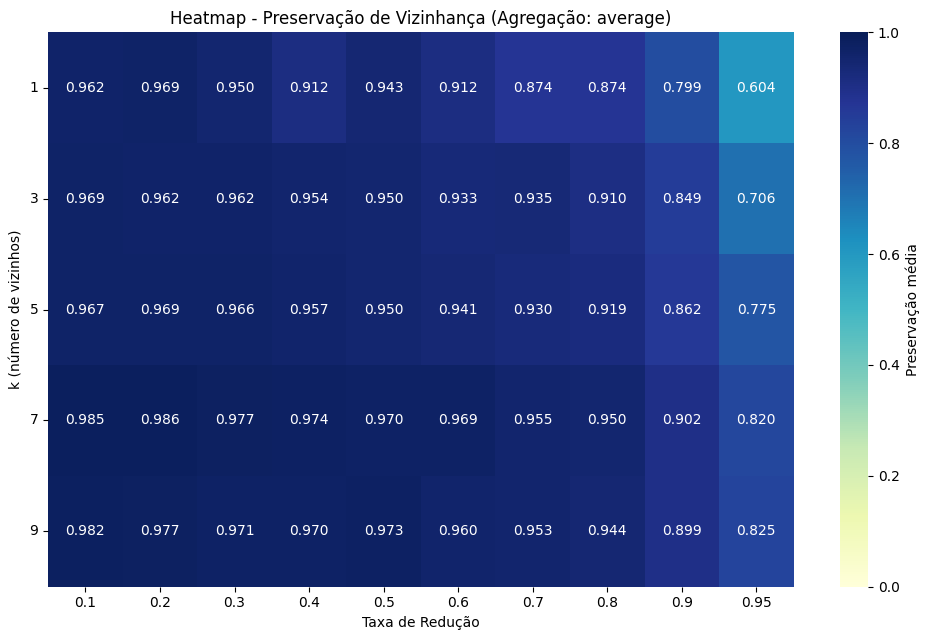

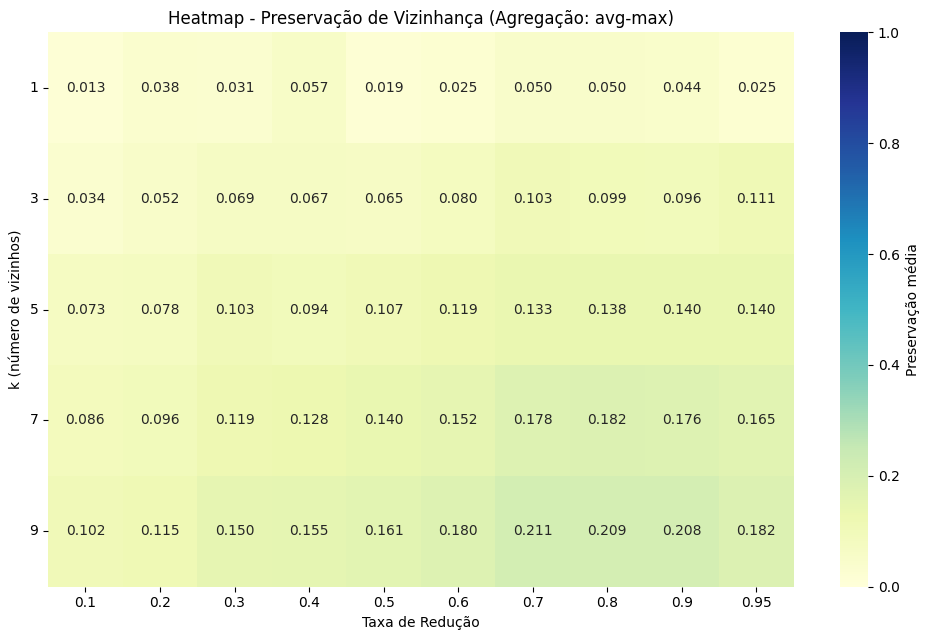

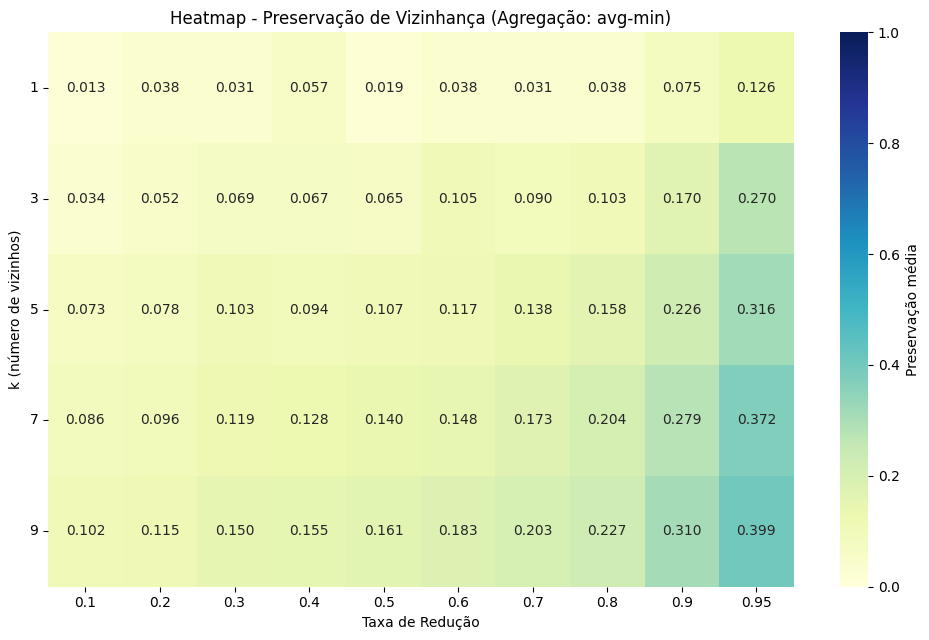

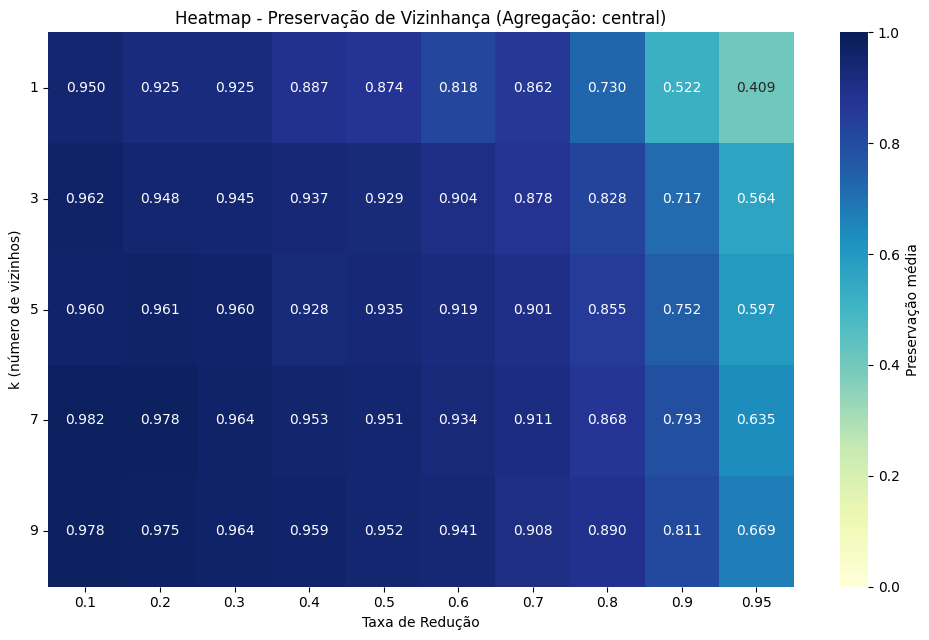

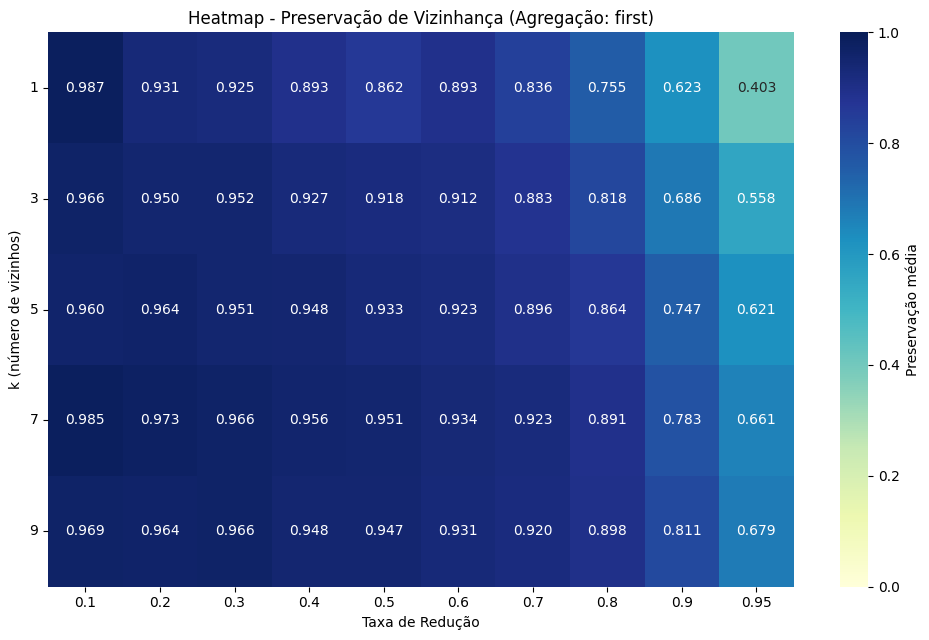

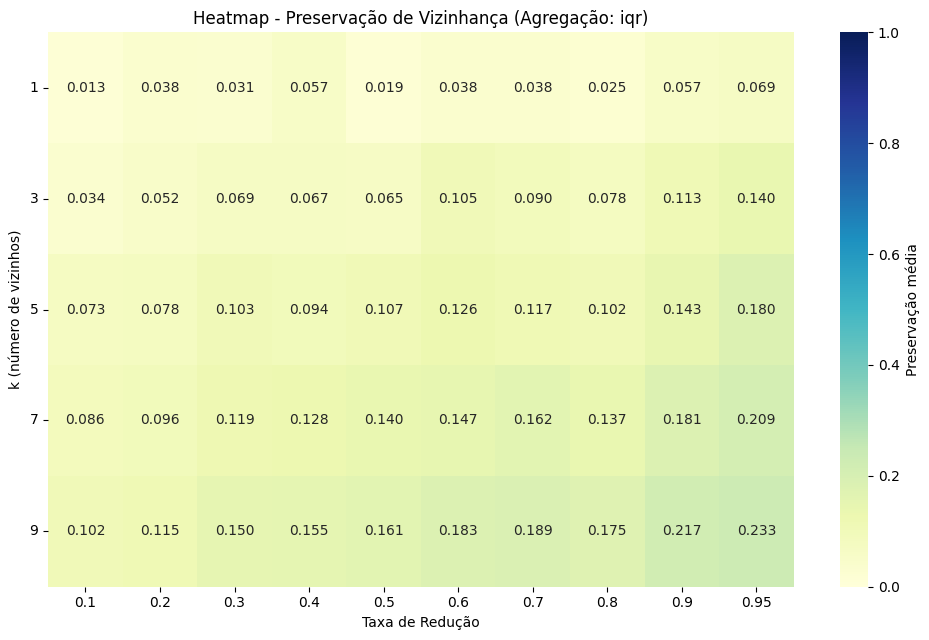

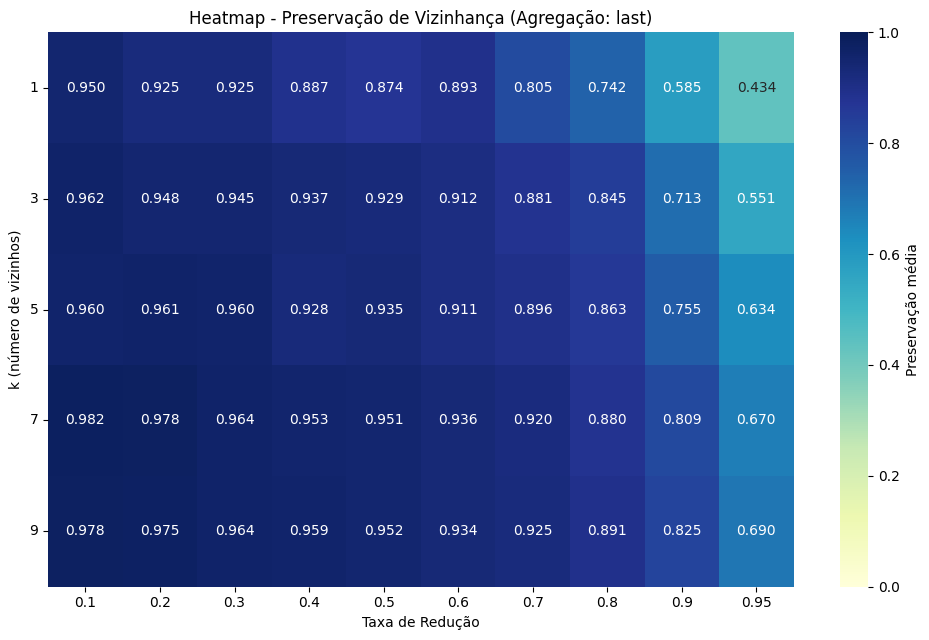

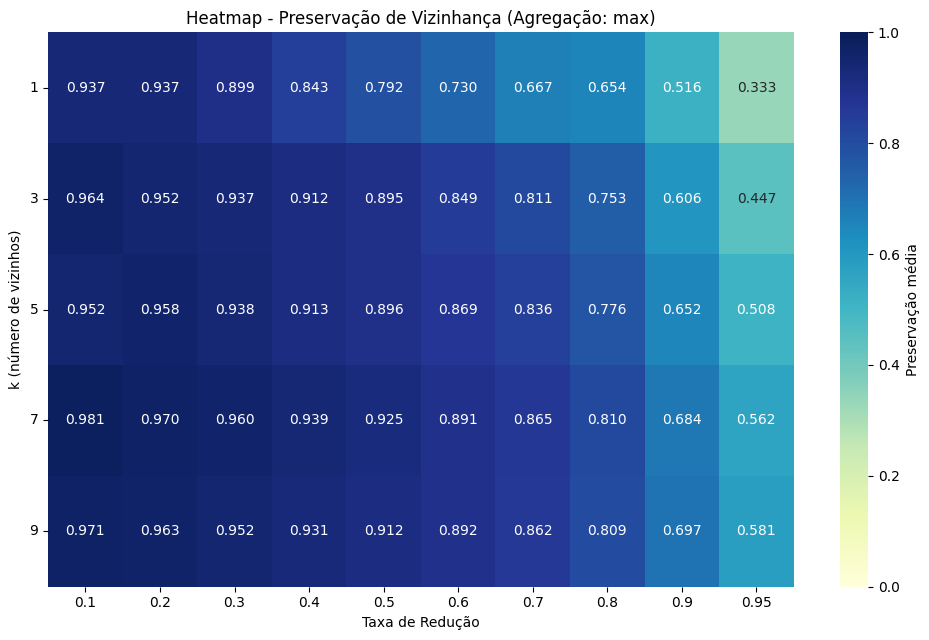

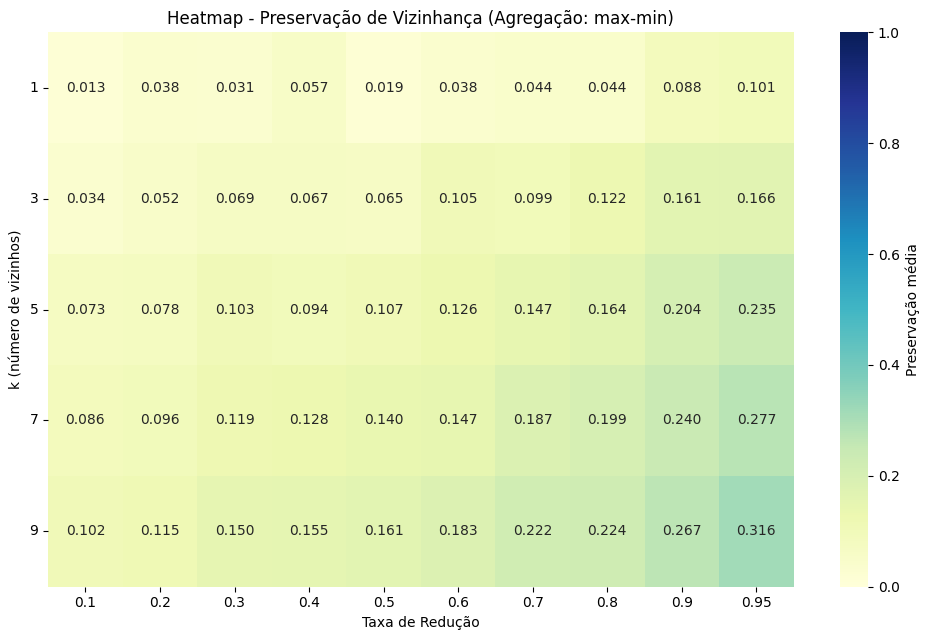

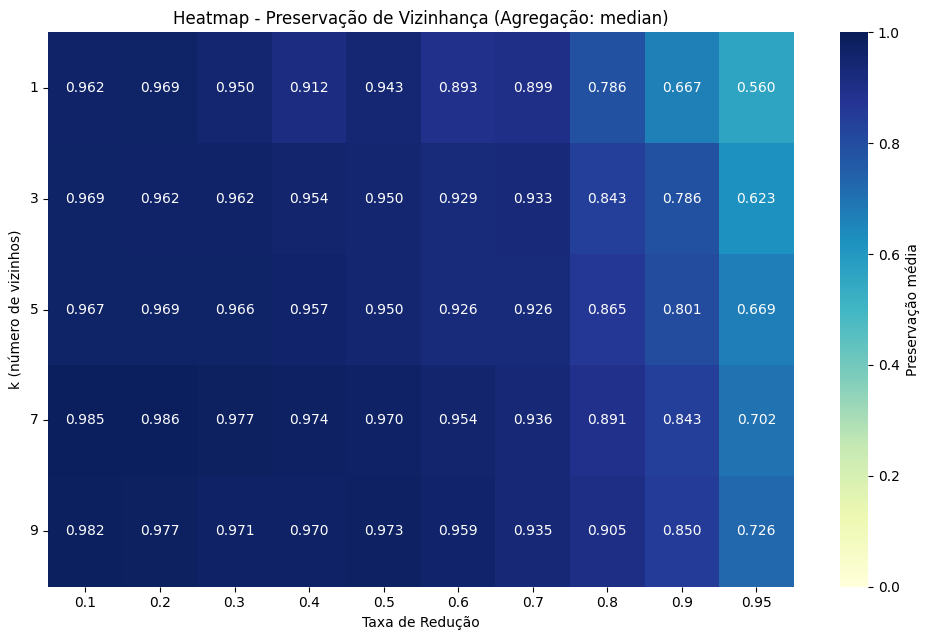

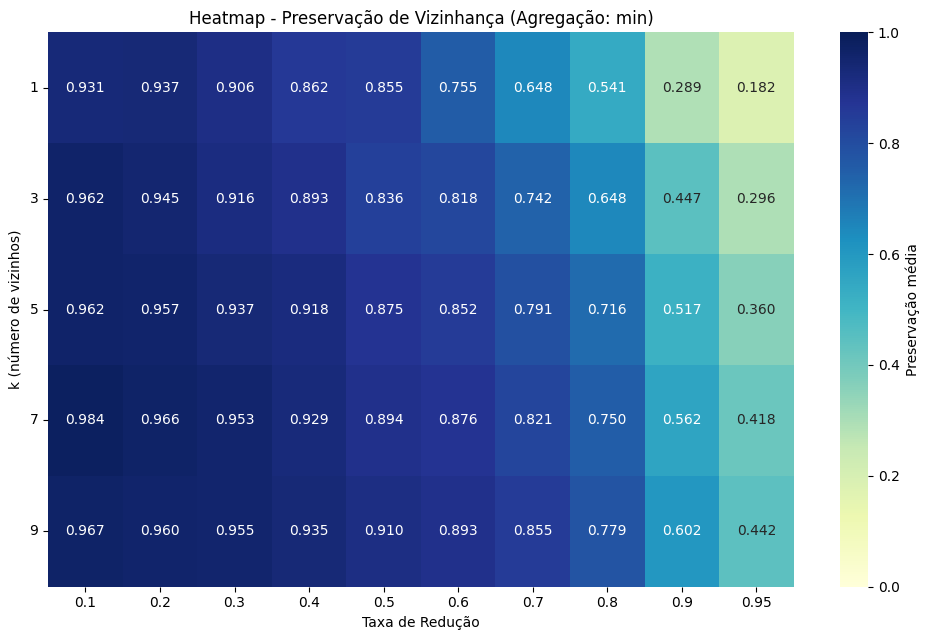

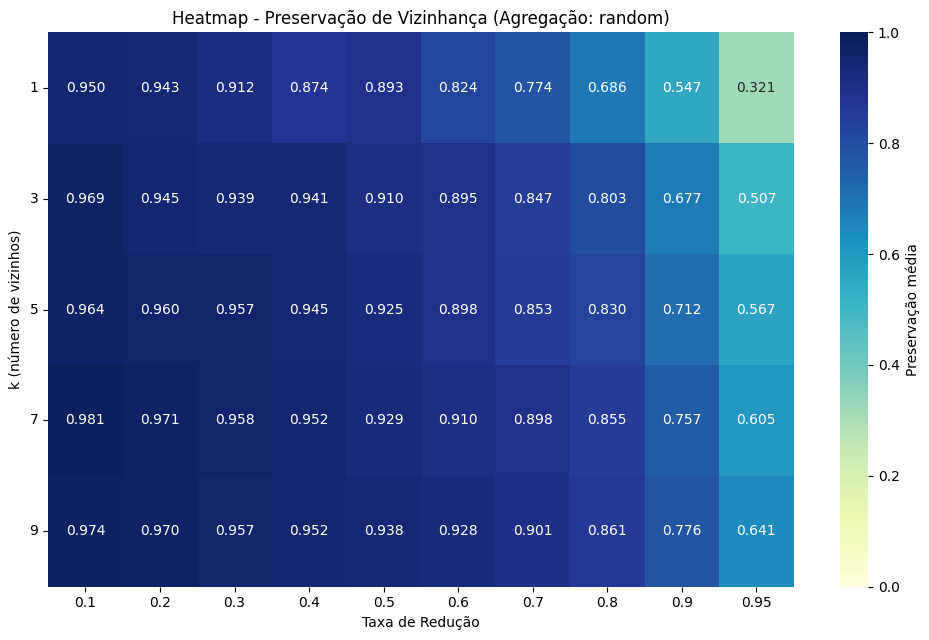

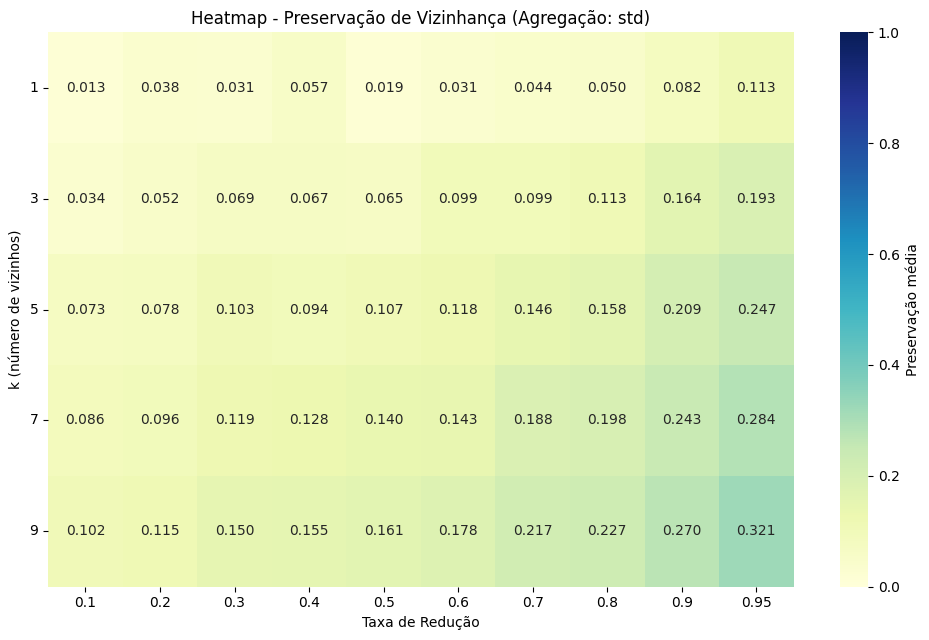

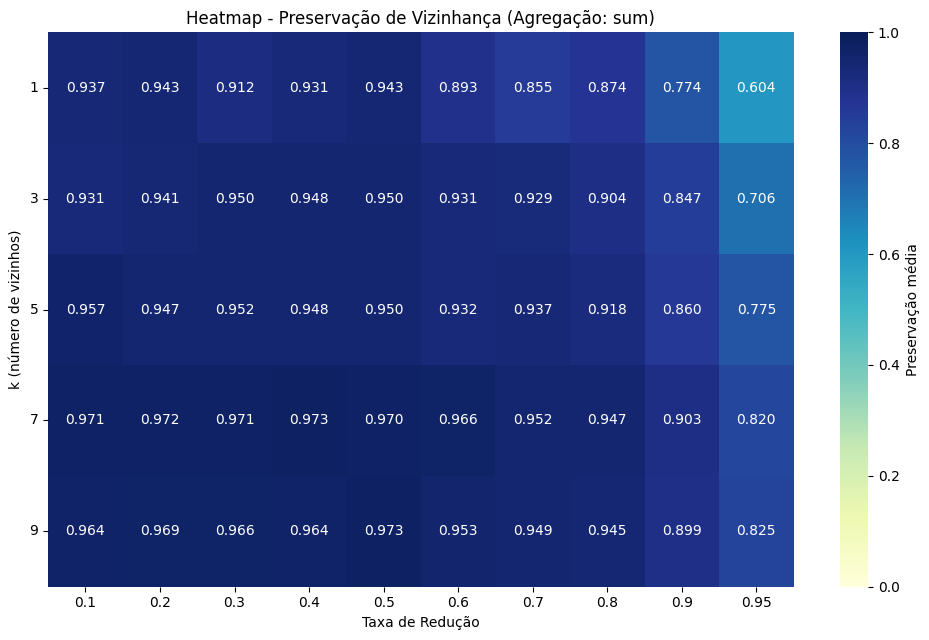

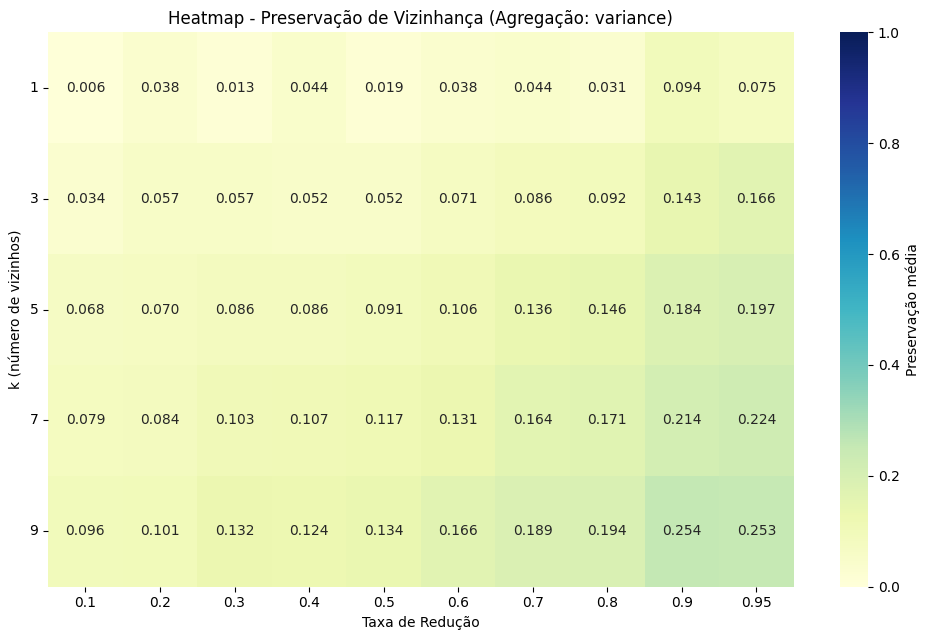

In [ ]:
# Plota um heatmap da pivot_table para cada método de agregação
agg_methods = pivot_table.index.get_level_values(0).unique()

for agg in agg_methods:
  # Seleciona a sub-tabela para o método de agregação (linhas = k, colunas = reduction_rate)
  df_heat = pivot_table.loc[agg]
  
  plt.figure(figsize=(10, 3 + 0.7 * len(df_heat)))  # ajusta altura conforme número de valores de k
  sns.heatmap(df_heat, annot=True, fmt=".3f", cmap="YlGnBu", vmin=0.0, vmax=1.0, cbar_kws={'label': 'Preservação média'})
  plt.title(f'Heatmap - Preservação de Vizinhança (Agregação: {agg})')
  plt.xlabel('Taxa de Redução')
  plt.ylabel('k (número de vizinhos)')
  plt.yticks(rotation=0)
  plt.tight_layout()
  plt.show()

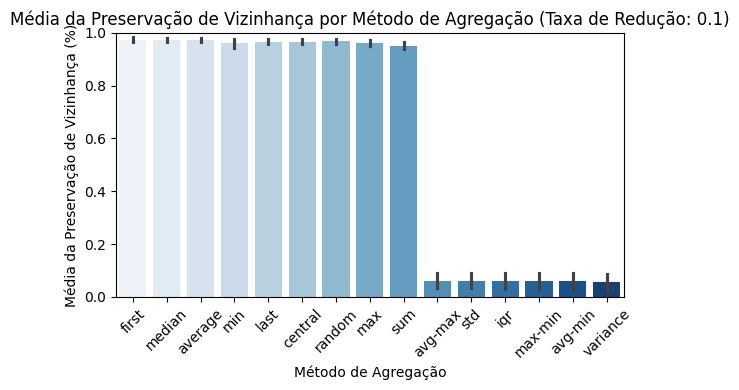

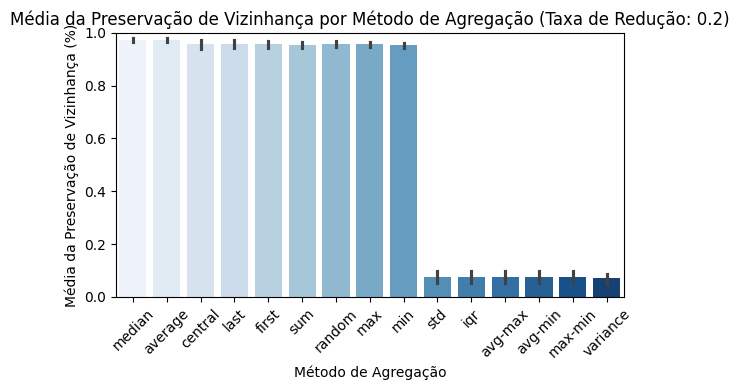

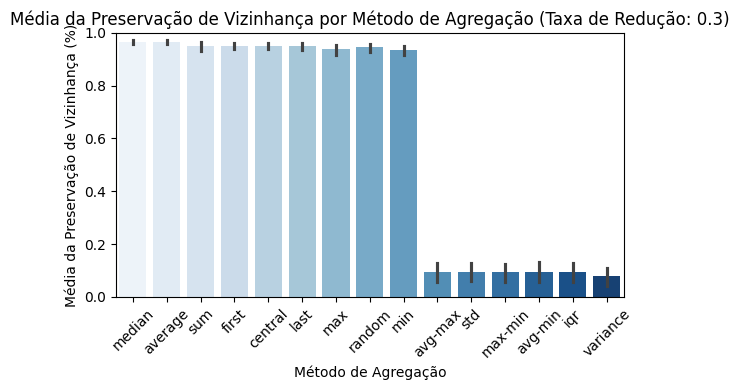

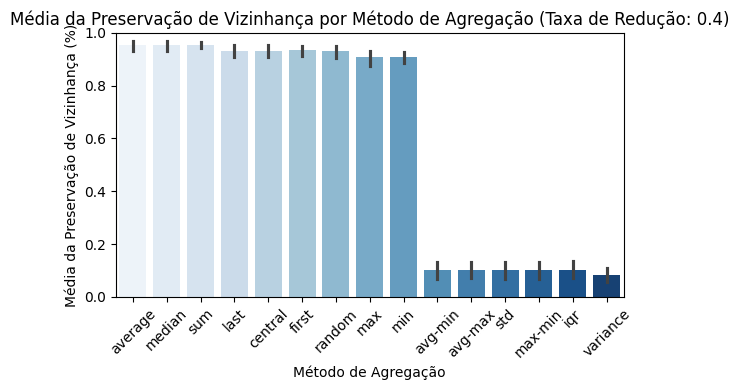

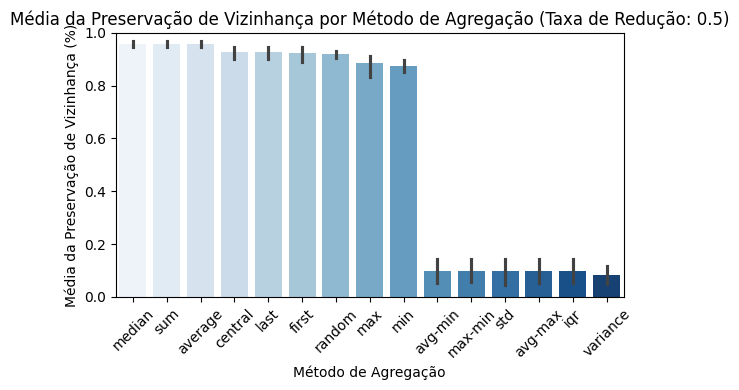

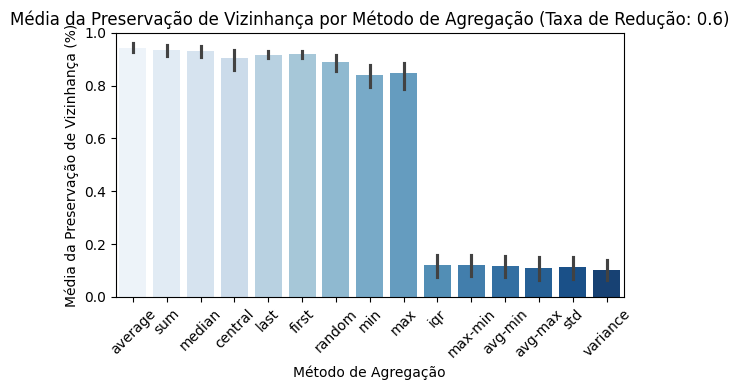

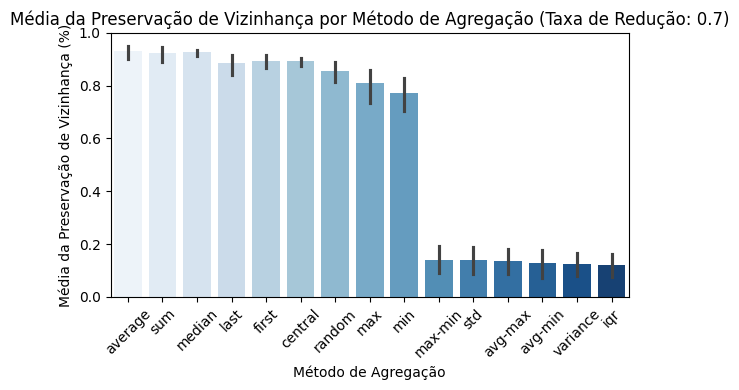

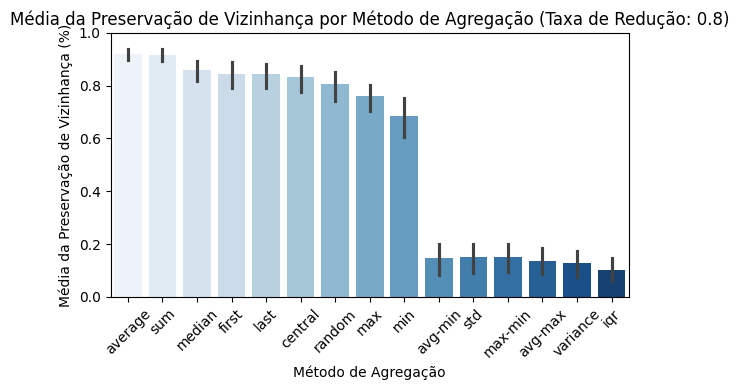

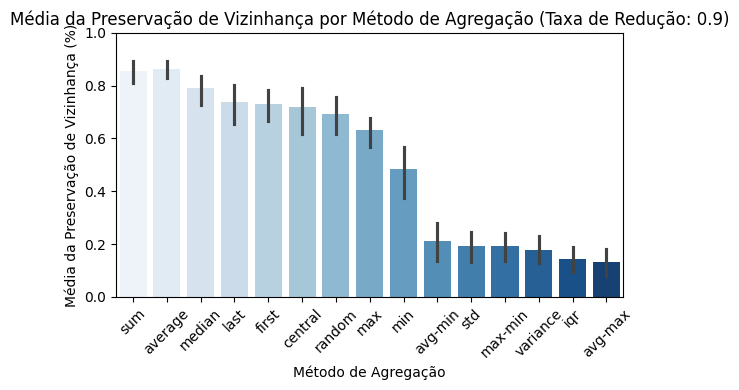

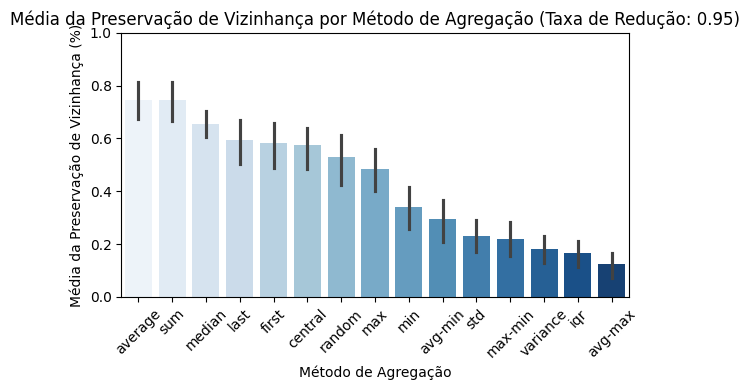

In [23]:
# Plota um gráfico de barras para visualizar a média da similaridade dos K vizinhos por método de agregação
rates = grouped_results['reduction_rate'].unique()
for rate in rates:
  plt.figure(figsize=(6, 4))
  sns.barplot(data=grouped_results[grouped_results['reduction_rate'] == rate], x='aggregation', y='neighborhood_preservation', palette='Blues', hue='aggregation')
  plt.title(f'Média da Preservação de Vizinhança por Método de Agregação (Taxa de Redução: {rate})')
  plt.xlabel('Método de Agregação')
  plt.ylabel('Média da Preservação de Vizinhança (%)')
  plt.xticks(rotation=45)
  plt.ylim(0, 1)
  plt.tight_layout()
  plt.show()